In [2]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

Assumptions:

1. Perfect thermal contact between the boundaries (i.e, the temperature at the mating surfaces are equal)
2. The temperature gradient in the polypropylene glass is assumed to be constant due to negligible thickness, i.e lumped capacitance analysis can be used in this case
3. 

In [3]:
def volume(r1,r2):
    return abs((4/3)*np.pi*(pow(r2/2,3) - pow(r1/2,3)))

def surfArea(r):
    return 4*np.pi*pow(r,2)

def diffusivity(k,rho,cp):
    return k/(rho*cp)

In [4]:
# Given parameters (_t thickness m) (_k conductivity W/mK) (_c sp. heat capacity at const pressure KJ/kg) (_lh latent heat KJ/kg) (_rho density kg/m^3)

# Outer Insulation
minWool_t = 50e-3
minWool_k = 34e-3
minWool_rho = 160.
minWool_cp = 1030.
minWool_tempInit = 18.

# # PolyPropylene 
# PP_t = 3.5e-3
# PP_k = 34e-3
# PP_rho = 905.
# PP_c = 1920.

# Dry Ice
co2_t = 30e-3
co2_k = 16e-3
co2_cp = 0.658e3
co2_rho = 1.977
# co2_k = 24.35e-3
# co2_cp = 1.006e3
# co2_rho = 120.276 
co2_h = 2.2
co2_tempInit = 0.

# PCM

PCM_k = 20. #2.5
PCM_c = 115.95440697 #2.5e3
PCM_h = 1.1 #2.0
PCM_t = 30e-3
# PCM_cp_liq = 3.40
# PCM_cp_sol = 1.87
# PCM_k_liq = 0.53
# PCM_k_sol = 5.26
# PCM_lh = 327.
PCM_rho = 1043.
PCM_tempInit = -25.

# Outside/ Ambient parameters

amb_h = 5. #w/m2K
amb_temp = 25. #c
coeff = 3.45735793

In [5]:
minWool_Diff = diffusivity(minWool_k,minWool_rho,minWool_cp)
co2_diff = diffusivity(co2_k,co2_rho,co2_cp)
# PP_diff = diffusivity(PP_k, PP_rho, PP_c)
PCM_diff = diffusivity(PCM_k, PCM_rho, PCM_c)


biot_minWool = amb_h*minWool_t/minWool_k
biot_co2 = co2_h*co2_t/co2_k
biot_PCM = PCM_h*PCM_t/PCM_k

In [6]:
def eigenRoots(Bi):

    val = []
    CN = []
    for n in range (1,500): val.append(fsolve(lambda y: y*np.tan(y) - Bi, n))
    uniqueRoots = np.unique(np.around(np.concatenate(val,axis=0), decimals=4)) #this nested function initially flattens the list of ndarray objects into individual numpy float64 elements which are then rounded to 4 decimal places and then the unique values of them are extracted using np.unique() function 
    for n in range(0,100):
        CN.append((4*np.sin(uniqueRoots[n])) / ((2*uniqueRoots[n]) + np.sin(2*uniqueRoots[n])))
        
    return uniqueRoots,CN

$ Bi = \frac{hL}{k} $

$ \zeta_n tan(\zeta_n) = Bi $

$ Fo = \frac{\alpha \cdot t}{L^2} $ 

$ x^* = \frac{x}{L} $

$ \theta^* = \sum_{n = 1}^{\infty} C_{n} exp(- \zeta_{n}^2 Fo) cos(\zeta_{n}x^*)$ 

$ \theta^* = \frac{T - T_{\infty}}{T_{i} - T_{\infty}} $

$ T_{(x,t)} = [(T_i - T_\infty) \cdot \sum_{n = 1}^{\infty} C_{n} exp(- \zeta_{n}^2 Fo) cos(\zeta_{n}x^*)] + T_\infty ] $

16.653046426400675
22.824687548267217


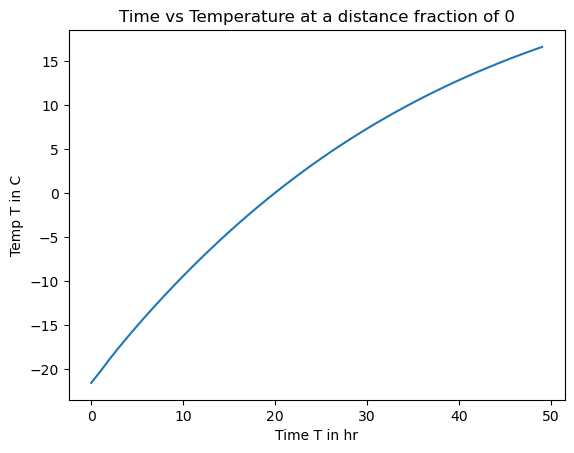

In [14]:
def tAtXandT(cn, z, a, t, l, xS):   
    fo =  a * t / l
    return cn * np.exp(-z**2 * fo) * np.cos(z*xS)

minWoolTvst = []
co2Tvst = []
PCMTvst = []
x = 0
time = 50 #in hours

U1,R1 = eigenRoots(biot_minWool)
U2,R2 = eigenRoots(biot_co2)
U3,R3 = eigenRoots(biot_PCM)

for t in range(0,time*3600,3600):
    theta = 0.0
    for i in range (0,100):
        theta += tAtXandT(R1[i], U1[i], minWool_Diff, t, minWool_t, x)
        minWool_tempxt = (minWool_tempInit - amb_temp)*theta + amb_temp
    minWoolTvst.append(minWool_tempxt)
    
    theta = 0.0 
    for i in range (0,100):
        theta += tAtXandT(R2[i], U2[i], co2_diff, t, co2_t, x)
        co2_tempxt = (co2_tempInit - minWool_tempxt)*theta + minWool_tempxt
    co2Tvst.append(co2_tempxt)
    
    theta = 0.0 
    for i in range (0,100):
        theta += tAtXandT(R3[i], U3[i], PCM_diff, t, PCM_t, 0.5)
        PCM_tempxt = (PCM_tempInit - co2_tempxt)*theta + co2_tempxt + coeff
    PCMTvst.append(PCM_tempxt)

plt.plot(PCMTvst)
plt.title(f'Time vs Temperature at a distance fraction of {x}')
plt.xlabel('Time T in hr')
plt.ylabel('Temp T in C')
print(PCMTvst[-1])
print(co2Tvst[-1])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


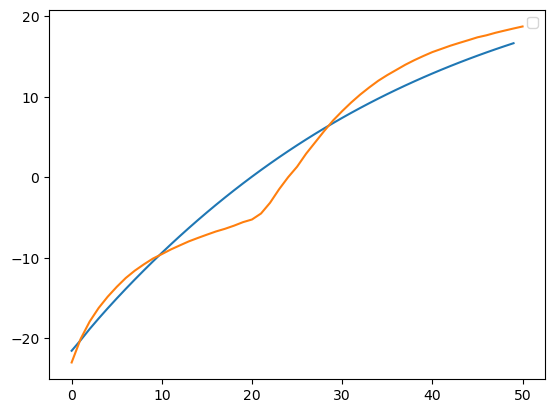

In [17]:
exp_val = np.loadtxt('data.txt')
exp_hr_val = exp_val[0:3022:60]
plt.plot(PCMTvst)
plt.plot(exp_hr_val)

plt.show()


20.444738646258912


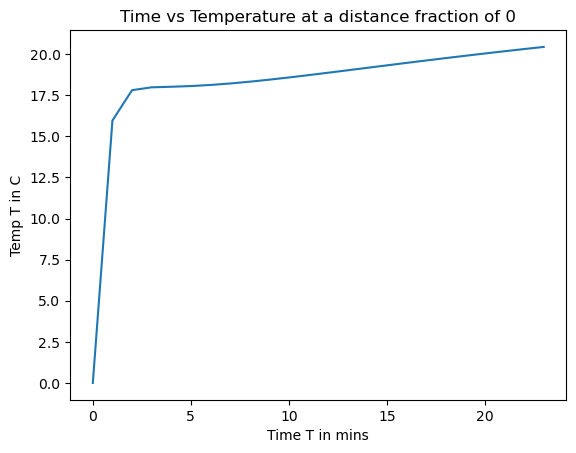

In [9]:
plt.plot(co2Tvst)
plt.title(f'Time vs Temperature at a distance fraction of {x}')
plt.xlabel('Time T in mins')
plt.ylabel('Temp T in C')
print(co2Tvst[-1])

The temperature at cold and hot ends are 18.0 and 22.451


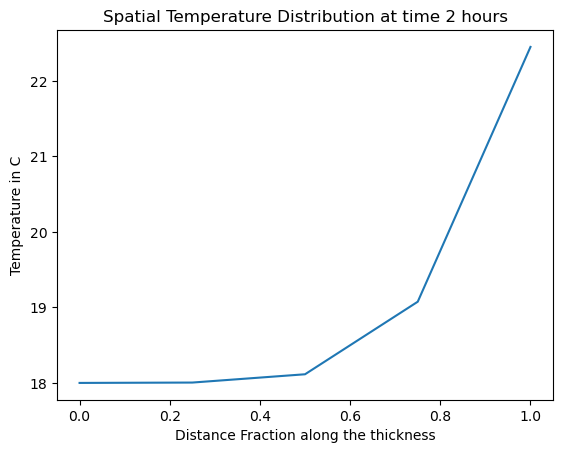

In [10]:
def minwoolSpVar(t):
    time = t*3600
    minwoolSpVarData = []
    spVar = np.linspace(0,1,5)
    for x in spVar:
        theta = 0.0
        for i in range(0,100):
            theta += tAtXandT(R1[i], U1[i], minWool_Diff, time, minWool_t, x)
        minWool_tempxt = (minWool_tempInit - amb_temp)*theta + amb_temp
        minwoolSpVarData.append(minWool_tempxt)
        
    plt.plot(spVar,minwoolSpVarData)
    plt.title(f'Spatial Temperature Distribution at time {t} hours' )
    plt.ylabel('Temperature in C')
    plt.xlabel('Distance Fraction along the thickness')
    
    print(f'The temperature at cold and hot ends are {round(minwoolSpVarData[0],3)} and {round(minwoolSpVarData[-1],3)}')
    
minwoolSpVar(2)

NameError: name 'minwoolSpVarData' is not defined

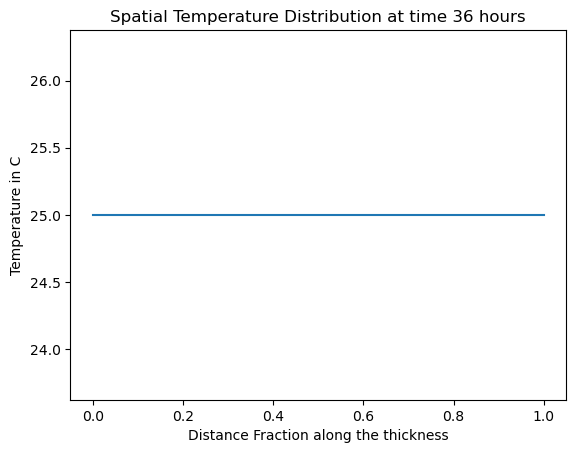

In [11]:
def co2spvar(t):
    time = t*3600
    SpVarData = []
    spVar = np.linspace(0,1,5)
    for x in spVar:
        theta = 0.0
        for i in range(0,100):
            theta += tAtXandT(R2[i], U2[i], co2_diff, time, co2_t, x)
        co2_tempxt = (minWool_tempInit - amb_temp)*theta + amb_temp
        SpVarData.append(co2_tempxt)
        
    plt.plot(spVar,SpVarData)
    plt.title(f'Spatial Temperature Distribution at time {t} hours' )
    plt.ylabel('Temperature in C')
    plt.xlabel('Distance Fraction along the thickness')
    
    print(f'The temperature at cold and hot ends are {round(minwoolSpVarData[0],3)} and {round(minwoolSpVarData[-1],3)}')
    
co2spvar(36)

for explicit method the stability criterion is given by $Fo \leq \frac{1}{2}$ 
and $ Fo $ is written as a dimensionless time constant as

 $ Fo = \frac{\alpha \cdot \Delta t}{L^2}$ thus finding the suitable time steps to meet the stability criterion and the $ \Delta x $ (distance between the nodes) is taken at 10mm


In [ ]:
# fo = 1/2
# nodalDist = 10e-3
# timeStep = fo * (nodalDist**2) / minWool_Diff
# q_outerFlux = amb_h/(abs(minWool_tempInit - amb_temp))
# bi = amb_h * nodalDist / minWool_k

ValueError: x and y must have same first dimension, but have shapes (5,) and (45,)

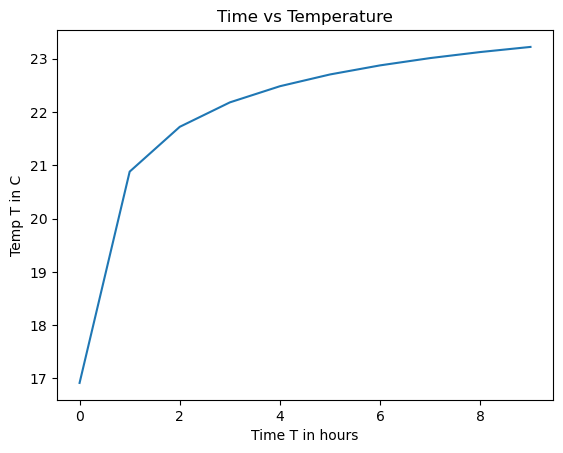

In [ ]:
# def tAtXandT(cn, z, a, t, l, xS):   
#     fo =  a * t / l
#     value = (cn * np.exp(-z**2 * fo) * np.cos(z*xS))     
#     return value

# minWoolTvst = []
# co2Tvst= []
# time = 10 #in hours
# for t in range(0,time*3600,3600):
#     theta = 0.0
#     for i in range (0,15):
#         theta = theta + tAtXandT(CN[i], uniqueRoots[i], minWool_Diff, t, minWool_t, 1)
#         minWool_tempxt = (minWool_tempInit - amb_temp)*theta + amb_temp
#     minWoolTvst.append(minWool_tempxt)

# plt.plot(minWoolTvst)
# plt.title('Time vs Temperature')
# plt.xlabel('Time T in hours')
# plt.ylabel('Temp T in C')

# def minwoolSpVar(t):
#     time = t*3600
#     minwoolSpVarData = []
#     spVar = np.linspace(0,1,5)
#     for x in spVar:
#         for y in range (0,time,3600):
#             theta = 0.0
#             for i in range(0,15):
#                 theta = theta + tAtXandT(CN[i], uniqueRoots[i], minWool_Diff, time, minWool_t, x)
#                 minWool_tempxt = (minWool_tempInit - amb_temp)*theta + amb_temp
#             minwoolSpVarData.append(minWool_tempxt)
        
#     plt.plot(spVar,minwoolSpVarData)
#     plt.title(f'Spatial Temperature Distribution at time {t} hours' )
#     plt.ylabel('Temperature in C')
#     plt.xlabel('Distance Fraction along the thickness')
    
#     print(f'The temperature at cold and hot ends are {round(minwoolSpVarData[0],2)} and {round(minwoolSpVarData[-1],2)}')
    
# minwoolSpVar(9)